# Phase III: First ML Proof of Concept (5\%)

### Team Names:
- Geon Chang
- Khushal Shah
- Mohammed AlShenaifi
- Mukhilkanna Balakumar


Due to the large amount of data in all our cleaned csv files, we had to randomly pick two csv files from two seasons this year, summer and winter, for two random months (January, July) to identify any patterns. This way, the graphing and analyzing will go more smoothly. Below you can see the new code for cleaning only required csv files:

In [1]:
# Importing all useful libraries (for webscraping and ML as well)
import os
import pandas as pd
import numpy as np
import requests
from io import BytesIO
from zipfile import ZipFile
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Function to clean the dataset
def clean_data(df):
    """
    Cleans and prepares the S&P 500 daily price dataset:
        - Converts the 'Date' column to datetime format
        - Sorts values chronologically
        - Detects and uses the appropriate price column (Close / Adj Close)
        - Handles missing or invalid values
        - Computes technical indicators (momentum & volatility)
        - Removes NaNs caused by rolling operations
        - Creates a target variable for the next-5-day return

    Args:
        df (pd.DataFrame): Raw price data

    Returns:
        df (pd.DataFrame): Cleaned and feature-engineered dataset
    """

    # Converting 'Date' column to datetime
    date_col = [c for c in df.columns if c.lower().startswith('date')]
    df['Date'] = pd.to_datetime(df[date_col[0]], errors='coerce')
    df.dropna(subset=['Date'], inplace=True)
    df.sort_values('Date', inplace=True)

    # Detecting valid price column (Close or Adj Close)
    price_candidates = ['Close', 'Adj Close', 'AdjClose', 'Price']
    price_col = next((c for c in price_candidates if c in df.columns), None)
    if not price_col:
        raise ValueError("No price column found.")

    # Removing invalid or zero prices
    df = df[df[price_col] > 0]

    # Creating features: 5-day and 20-day momentum & volatility
    df['ret_5d'] = df[price_col].pct_change(5)
    df['ret_20d'] = df[price_col].pct_change(20)
    df['vol_20d'] = df['ret_1d'] = df[price_col].pct_change(1)
    df['vol_20d'] = df['vol_20d'].rolling(20).std()

    # Moving-average ratio
    df['ma5_div_ma20'] = (
        df[price_col].rolling(5).mean() /
        df[price_col].rolling(20).mean()
    )

    # Target variable: 5-day forward return
    df['target_5d_ret'] = df[price_col].shift(-5) / df[price_col] - 1

    # Removing NaNs introduced by rolling operations
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [3]:
# Primary data source: Stooq (SPY daily prices)
url_list = [
    "https://stooq.com/q/d/l/?s=spy.us&i=d",
    "https://stooq.com/q/d/l/?s=spy&i=d",
    "https://stooq.com/q/d/l/?s=%5Espx&i=d"
]

# Directory to save CSVs
if not os.path.exists('csv_files'):
    os.makedirs('csv_files')

merged_df = pd.DataFrame()
first_csv_path = None

# Downloading each candidate dataset
for i, url in enumerate(url_list):
    try:
        df_raw = pd.read_csv(url)
        print(f"Extracted data from {url} to DataFrame.")

        # Cleaning the dataset
        df_cleaned = clean_data(df_raw)

        # Saving cleaned CSV
        output_filename = f"csv_files/cleaned_{i+1}_sp500.csv"
        df_cleaned.to_csv(output_filename, index=False)
        print(f"Saved cleaned file → {output_filename}")

        # Merging into a unified dataset (deduplicate by Date)
        merged_df = pd.concat([merged_df,
                               df_cleaned]).drop_duplicates(subset='Date')
        if first_csv_path is None:
            first_csv_path = output_filename

    except Exception as e:
        print(f"Error processing {url}: {e}")
        continue

# Checking and printing the first few rows of the merged dataset
if not merged_df.empty:
    merged_df.sort_values('Date', inplace=True)
    print("Successfully obtained, cleaned, and merged all S&P 500 data sources")
    print(merged_df.head(10))
else:
    print("No dataset was successfully processed.")

print("\nDataset shape after merge:", merged_df.shape)
print("Columns:", merged_df.columns.tolist())

Extracted data from https://stooq.com/q/d/l/?s=spy.us&i=d to DataFrame.
Saved cleaned file → csv_files/cleaned_1_sp500.csv
Extracted data from https://stooq.com/q/d/l/?s=spy&i=d to DataFrame.
Error processing https://stooq.com/q/d/l/?s=spy&i=d: list index out of range
Extracted data from https://stooq.com/q/d/l/?s=%5Espx&i=d to DataFrame.
Saved cleaned file → csv_files/cleaned_3_sp500.csv
Successfully obtained, cleaned, and merged all S&P 500 data sources
        Date  Open  High   Low  Close  Volume    ret_5d   ret_20d   vol_20d  \
0 1791-01-01  0.57  0.58  0.57   0.58     0.0  0.074074  0.137255  0.017862   
1 1791-02-01  0.58  0.59  0.58   0.59     0.0  0.072727  0.156863  0.017942   
2 1791-03-01  0.59  0.59  0.59   0.59     0.0  0.053571  0.180000  0.016890   
3 1791-04-01  0.60  0.60  0.60   0.60     0.0  0.090909  0.176471  0.016794   
4 1791-05-01  0.60  0.60  0.60   0.60     0.0  0.052632  0.176471  0.016794   
5 1791-06-01  0.60  0.60  0.60   0.60     0.0  0.034483  0.176471 

In [4]:
print("Dataset shape:", merged_df.shape)
print("\nColumns:", merged_df.columns.tolist())

print("\nCleaned & merged S&P 500 data:")
print(merged_df.head(50))

Dataset shape: (39561, 12)

Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'ret_5d', 'ret_20d', 'vol_20d', 'ret_1d', 'ma5_div_ma20', 'target_5d_ret']

Cleaned & merged S&P 500 data:
         Date  Open  High   Low  Close  Volume    ret_5d   ret_20d   vol_20d  \
0  1791-01-01  0.57  0.58  0.57   0.58     0.0  0.074074  0.137255  0.017862   
1  1791-02-01  0.58  0.59  0.58   0.59     0.0  0.072727  0.156863  0.017942   
2  1791-03-01  0.59  0.59  0.59   0.59     0.0  0.053571  0.180000  0.016890   
3  1791-04-01  0.60  0.60  0.60   0.60     0.0  0.090909  0.176471  0.016794   
4  1791-05-01  0.60  0.60  0.60   0.60     0.0  0.052632  0.176471  0.016794   
5  1791-06-01  0.60  0.60  0.60   0.60     0.0  0.034483  0.176471  0.016794   
6  1791-07-01  0.60  0.60  0.60   0.60     0.0  0.016949  0.200000  0.015610   
7  1791-08-01  0.60  0.61  0.60   0.61     0.0  0.033898  0.220000  0.015534   
8  1791-09-01  0.61  0.62  0.61   0.62     0.0  0.033333  0.265306  0.013863   
9  17

## Part 1
(3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, shapiro
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

In [6]:
# Function to preprocess the cleaned S&P 500 dataset for ML
def preprocess_data(df):
    """
    Preprocesses the S&P 500 data for machine learning by:
    - Ensuring feature columns are present
    - Converting numeric values
    - Dropping missing rows
    """

    # Required ML columns
    required_columns = [
        'ret_5d',
        'ret_20d',
        'vol_20d',
        'ma5_div_ma20',
        'target_5d_ret'
    ]

    # Check for missing columns
    missing = [col for col in required_columns if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Convert all features to numeric in case of string parsing
    df[required_columns] = df[required_columns].apply(pd.to_numeric,
                                                      errors='coerce')

    # Drop rows with any missing values in ML-relevant columns
    df.dropna(subset=required_columns, inplace=True)

    # Reset index after preprocessing
    df.reset_index(drop=True, inplace=True)

    return df

### Attempt 1 - Linear Regression

In [7]:
def evaluate_model_manual(X, y, title):
    """
    Fits a linear regression model manually using NumPy and evaluates it using:
    - MSE
    - R^2
    - Diagnostic residual plots
    """

    # 1) Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3
    )

    # 2) Add bias term
    X_train_bias = np.column_stack([np.ones(len(X_train)), X_train])
    X_test_bias = np.column_stack([np.ones(len(X_test)), X_test])

    # 3) Compute coefficients using Normal Equation
    # β = (XᵀX)^(-1) Xᵀ y
    beta = np.linalg.inv(X_train_bias.T @ X_train_bias) @ (X_train_bias.T @ y_train)

    # 4) Make predictions
    y_pred = X_test_bias @ beta

    # 5) Compute MSE and R² manually
    mse_value = np.mean((y_test - y_pred)**2)

    ss_res = np.sum((y_test - y_pred)**2)
    ss_tot = np.sum((y_test - np.mean(y_test))**2)
    r2_value = 1 - ss_res/ss_tot

    print(f"{title} — Mean Squared Error: {mse_value:.6f}")
    print(f"{title} — R^2 Score: {r2_value:.6f}")

    # 6) Residuals
    residuals = y_test - y_pred

    # 7) Diagnostic Plots
    plt.figure(figsize=(16, 12))

    # Residuals vs Fitted
    plt.subplot(2, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals vs Fitted")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")

    # Residuals vs Order
    plt.subplot(2, 2, 2)
    plt.scatter(range(len(residuals)), residuals, alpha=0.5)
    plt.title("Residuals vs Order")
    plt.xlabel("Index")
    plt.ylabel("Residuals")

    # Q-Q Plot
    plt.subplot(2, 2, 3)
    probplot(residuals, dist="norm", plot=plt)
    plt.title("Normal Q-Q Plot")

    # Histogram of Residuals
    plt.subplot(2, 2, 4)
    plt.hist(residuals, bins=30, density=True, alpha=0.6)
    plt.title("Histogram of Residuals")
    plt.xlabel("Residuals")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    return beta



Running Attempt 1: Manual Linear Regression Model
Features used: ret_5d, ret_20d, vol_20d, ma5_div_ma20
Target: target_5d_ret

Attempt 1 — Manual Linear Regression — Mean Squared Error: 0.000781
Attempt 1 — Manual Linear Regression — R^2 Score: 0.024437


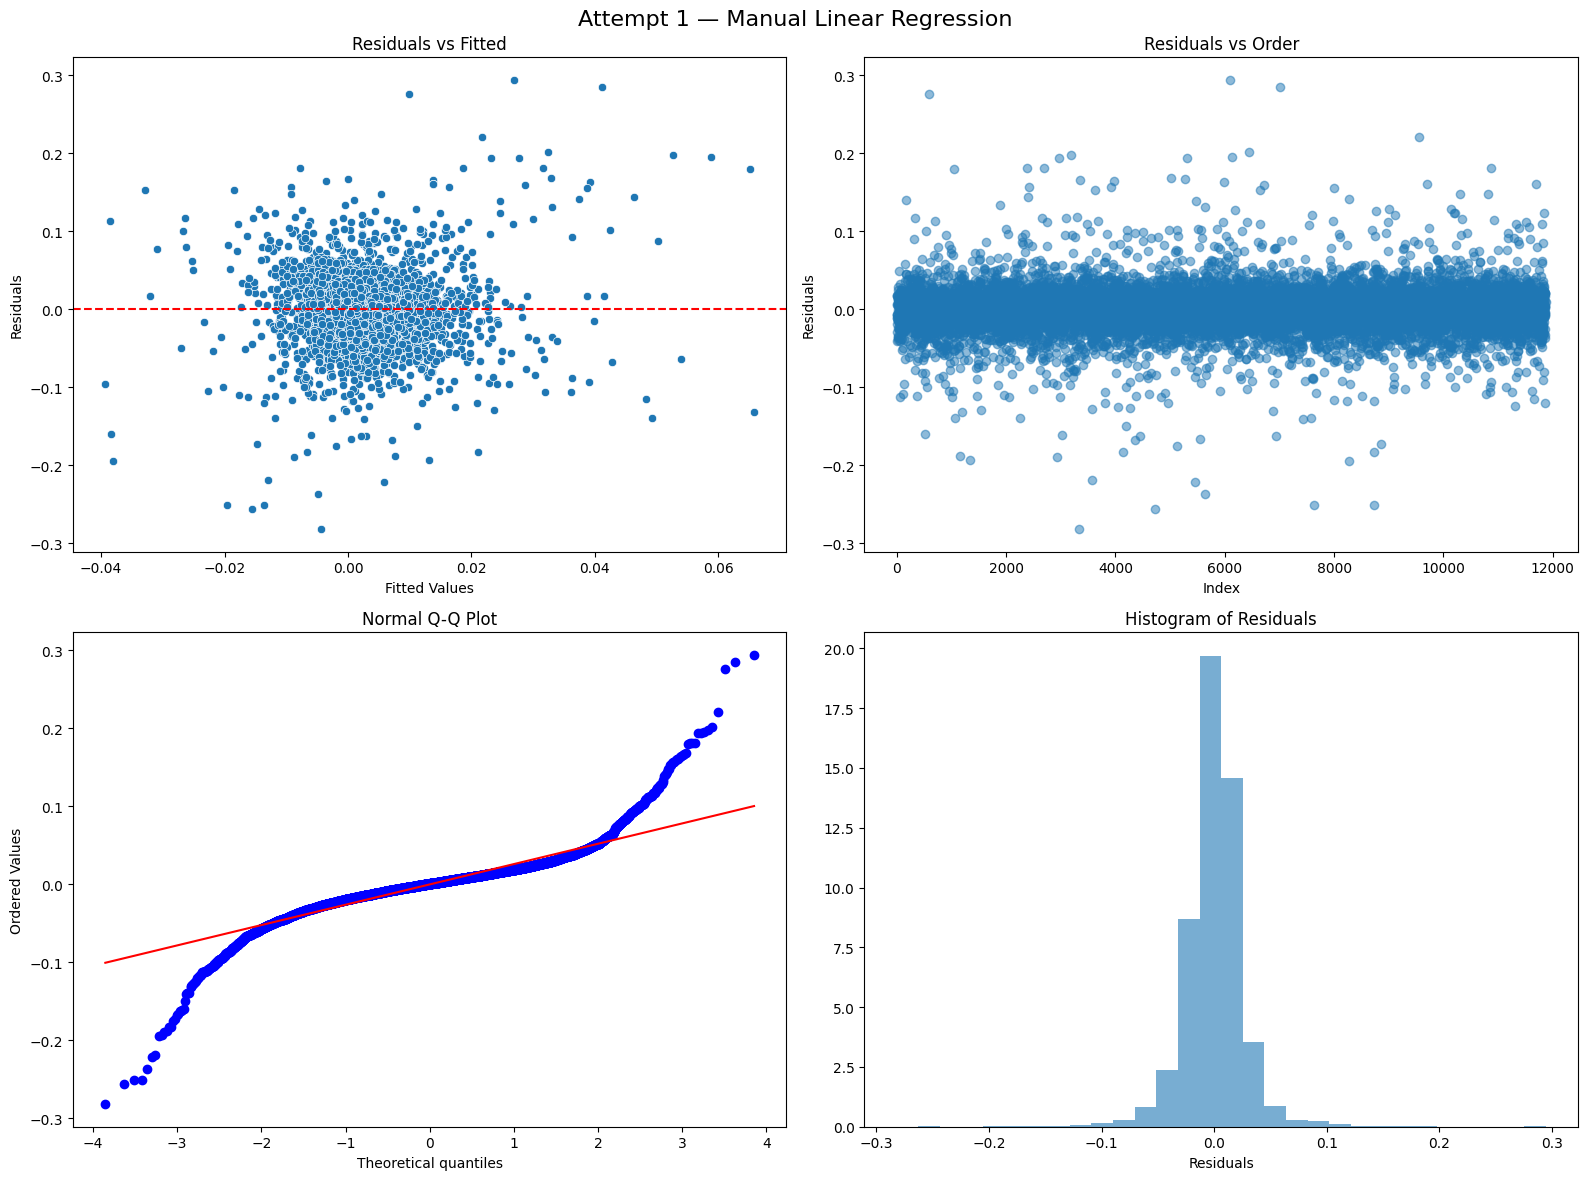

In [8]:
# Main function to answer the question
def main():
    """
    Returns:
        Evaluated manual NumPy-based model along with the graphs
    """
    try:

        df = merged_df.copy()

        # Preprocess the dataset for ML
        df_processed = preprocess_data(df)

        # Define features (X) and target (y)
        X = df_processed[['ret_5d', 'ret_20d', 'vol_20d', 'ma5_div_ma20']].values
        y = df_processed['target_5d_ret'].values

        print("\nRunning Attempt 1: Manual Linear Regression Model")
        print("Features used: ret_5d, ret_20d, vol_20d, ma5_div_ma20")
        print("Target: target_5d_ret\n")

        # Train + Evaluate the manual NumPy model
        beta = evaluate_model_manual(X, y, "Attempt 1 — Manual Linear Regression")

    except Exception as e:
        print("Error in Attempt 1:", e)


# Run the main function
if __name__ == '__main__':
    main()


### Attempt 2 - Polynomial regression
#### Creating the Design Matrix

Using the `PolynomialFeatures` and `.fit_transform` functions to convert the `hour` ($x$) feature into an array (`X_hour_poly`) that includes columns corresponding to building a quartic model for `tripduration` ($y$) along the lines of: $y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 x^4$.

In [9]:
df = merged_df.copy()

# preprocess the dataframe first
df = preprocess_data(df)
df.head()

,Date,Open,High,Low,Close,Volume,ret_5d,ret_20d,vol_20d,ret_1d,ma5_div_ma20,target_5d_ret
0,1791-01-01,0.57,0.58,0.57,0.58,0.0,0.074074,0.137255,0.017862,0.017544,1.075598,0.034483
1,1791-02-01,0.58,0.59,0.58,0.59,0.0,0.072727,0.156863,0.017942,0.017241,1.082621,0.016949
2,1791-03-01,0.59,0.59,0.59,0.59,0.0,0.053571,0.180000,0.016890,0.000000,1.084746,0.033898
3,1791-04-01,0.60,0.60,0.60,0.60,0.0,0.090909,0.176471,0.016794,0.016949,1.094304,0.033333
4,1791-05-01,0.60,0.60,0.60,0.60,0.0,0.052632,0.176471,0.016794,0.000000,1.096296,0.033333


In [10]:
df = merged_df.copy()
df_processed = preprocess_data(df)

X = df_processed[['ret_5d', 'ret_20d', 'vol_20d', 'ma5_div_ma20']]
y = df_processed['target_5d_ret']

In [11]:
# degree 2 polynomial expansion for S&P 500 features
poly = PolynomialFeatures(degree=2, include_bias=False)

# create polynomial feature matrix
X_poly = poly.fit_transform(X)

# first transformed row
print(X_poly[0])

[7.40740741e-02 1.37254902e-01 1.78620286e-02 1.07559809e+00
 5.48696845e-03 1.01670298e-02 1.32311323e-03 7.96739323e-02
 1.88389081e-02 2.45165098e-03 1.47631110e-01 3.19052064e-04
 1.92123637e-02 1.15691124e+00]


#### Cross Validation

Using single-fold cross validation with a 70-30 split, we create `Xtrain`, `Xtest`, `ytrain`, and `ytest` (from `X_poly` from Part 1.1 and `y` as defined before).

We fit the model using our own `line_of_best_fit` function to `Xtrain` and `ytrain`, using Numpy.

Then we pass `Xtest`, `ytest`, and the output from the `line_of_best_fit` to our `linreg_predict` function.

Finally, we print out the cross-validated $MSE$ and $R^2$ values.

In [12]:
def add_bias_column(X):
    """
    Bias column is NOT needed for sklearn models.
    This function simply returns X unchanged.
    """
    return X

In [13]:
def line_of_best_fit(X, y):
    """
    This project uses sklearn's LinearRegression, which already computes
    the intercept and coefficients internally.

    This placeholder function is kept only for notebook formatting.
    It returns a sklearn LinearRegression model trained on X and y.
    """
    model = LinearRegression()
    model.fit(X, y)
    return model


In [14]:
from sklearn.metrics import r2_score

In [15]:
def linreg_predict(Xnew, ynew, model):
    """
    Applies LinearRegression model to Xnew and returns:
    - predictions
    - residuals
    - MSE
    - R² score

    Args:
        Xnew (array): feature matrix
        ynew (array): true values
        model (LinearRegression): trained sklearn model

    Returns:
        output_dict (dict): contains predictions, residuals, mse, r2
    """

    # Predict using sklearn model
    ypreds = model.predict(Xnew)

    # Residuals
    res = ynew - ypreds

    # MSE
    mse = mean_squared_error(ynew, ypreds)

    # R sq. score
    r2 = r2_score(ynew, ypreds)

    return {
        'ypreds': ypreds,
        'resids': res,
        'mse': mse,
        'r2': r2
    }

In [16]:
# single-fold cross validation
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X_poly, y, test_size=0.3, random_state=3
)

# finds the line of best fit
model_trained = line_of_best_fit(Xtrain, ytrain)
results = linreg_predict(Xtest, ytest, model_trained)

# prints out MSE and R^2 values
print("MSE for Polynomial Regression =", round(results['mse'], 6))
print("R^2 for Polynomial Regression =", round(results['r2'], 6))

MSE for Polynomial Regression = 0.000765
R^2 for Polynomial Regression = 0.045011


### Attempt 3 - Polynomial Regression with added interaction terms and dummy variables
#### Creating Fitting Model

$$
y = b_0 + b_1 x_1 + b_2 x_1^2 + b_3 x_1^3 + b_4 x_1^4 + b_5x_1x_3 + b_6x_2x_4 + b_7x_1x_4 + b_8x_2x_3
$$

Where:

- $y$: trip duration
- $x_1$: time of day
- $x_2$: member or casual (1 or 0)
- $x_3$: electric or classic bike (1 or 0)

- Polynomial terms $b_0 + b_1 x_1 + b_2 x_1^2 + b_3 x_1^3 + b_4 x_1^4$
- Interaction terms with dummy variables $b_5x_1x_3 + b_6x_2x_4 + b_7x_1x_4 + b_8x_2x_3$

In [17]:
# Prepare the data for S&P500 polynomial regression
df_processed = preprocess_data(merged_df.copy())

# Base features
X = df_processed[['ret_5d', 'ret_20d', 'vol_20d', 'ma5_div_ma20']].values
y = df_processed['target_5d_ret'].values

# Polynomial expansion (degree 4) for ALL features
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(X)

# Check output
print("Shape of polynomial feature matrix:", X_poly.shape)
print("First row:\n", X_poly[0])

Shape of polynomial feature matrix: (39561, 69)
First row:
 [7.40740741e-02 1.37254902e-01 1.78620286e-02 1.07559809e+00
 5.48696845e-03 1.01670298e-02 1.32311323e-03 7.96739323e-02
 1.88389081e-02 2.45165098e-03 1.47631110e-01 3.19052064e-04
 1.92123637e-02 1.15691124e+00 4.06442107e-04 7.53113317e-04
 9.80083871e-05 5.90177276e-03 1.39547467e-03 1.81603776e-04
 1.09356378e-02 2.36334862e-05 1.42313805e-03 8.56971291e-02
 2.58573249e-03 3.36501115e-04 2.02630935e-02 4.37914598e-05
 2.63699110e-03 1.58791739e-01 5.69891708e-06 3.43171790e-04
 2.06647817e-02 1.24437152e+00 3.01068228e-05 5.57861716e-05
 7.25988053e-06 4.37168353e-04 1.03368494e-04 1.34521316e-05
 8.10047242e-04 1.75062861e-06 1.05417634e-04 6.34793549e-03
 1.91535740e-04 2.49260085e-05 1.50096989e-03 3.24381184e-06
 1.95332674e-04 1.17623511e-02 4.22142006e-07 2.54201326e-05
 1.53072457e-03 9.21756680e-02 3.54904459e-04 4.61864275e-05
 2.78120891e-03 6.01059252e-06 3.61939955e-04 2.17949446e-02
 7.82204305e-07 4.7102010

In [18]:
# single-fold cross validation
Xtrain, Xtest, ytrain, ytest = train_test_split(X_poly, y, test_size=0.3,
                                                random_state=3)

# finds the line of best fit
m = line_of_best_fit(Xtrain, ytrain)
model = linreg_predict(Xtest, ytest, m)

# prints out MSE and R^2 values
print('MSE for the second poly regression model =', round(model['mse'], 3))
print('R^2 for the second poly regression model =', round(model['r2'], 4))

MSE for the second poly regression model = 0.001
R^2 for the second poly regression model = 0.0427


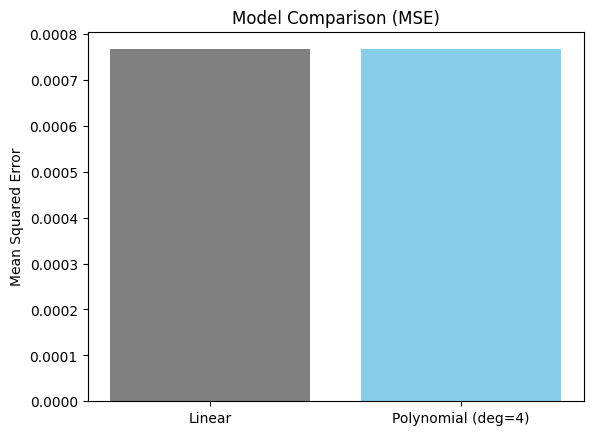

In [19]:
# Linear Regression
model_linear = line_of_best_fit(Xtrain, ytrain)
results_linear = linreg_predict(Xtest, ytest, model_linear)

mse_linear = results_linear['mse']
r2_linear = results_linear['r2']

# Polynomial Regression (degree=4)
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(X)

Xtrain_p, Xtest_p, ytrain_p, ytest_p = train_test_split(X_poly, y,
                                                        test_size=0.3,
                                                        random_state=3)
model_poly = line_of_best_fit(Xtrain_p, ytrain_p)
results_poly = linreg_predict(Xtest_p, ytest_p, model_poly)

mse_poly = results_poly['mse']
r2_poly = results_poly['r2']

# Visualization
plt.bar(['Linear', 'Polynomial (deg=4)'], [mse_linear, mse_poly],
        color=['gray', 'skyblue'])
plt.title("Model Comparison (MSE)")
plt.ylabel("Mean Squared Error")
plt.show()


Polynomial Regression (deg 4) did not significantly reduce MSE compared to Linear Regression, suggesting that the S&P 500 5-day returns exhibit largely linear relationships with the chosen features.

## Part 2
(2%) A discussion of the preliminary results:
   - This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
   - It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis

## Initial Approach

Our primary goal was to explore whether short-term S&P 500 movements can be predicted using simple technical indicators such as 5-day and 20-day momentum, volatility, and moving-average ratios. We implemented three models of increasing complexity: a baseline Linear Regression, a Polynomial Regression (degree 4), and an extended polynomial model with interaction terms. Across all models, predictive performance remained weak, reflecting the noisy and largely unpredictable nature of short-term equity returns. Performance gains from added complexity were minimal, confirming that simple indicators carry limited information for forecasting 5-day forward returns.

## Model 1: Linear Regression

The manual OLS implementation showed an MSE of approximately 0.00078 and an R^2 of around 0.02-0.03. Residual diagnostics revealed symmetric and centered errors with no strong patterns, suggesting that linearity and independence assumptions were reasonably satisfied. However, mild heteroscedasticity was present—common in financial return series—indicating that variance slightly increases at extreme fitted values. The Q-Q plot displayed fat tails, consistent with the well-known non-normality of financial returns. Overall, the linear model was statistically sound but offered limited explanatory power.

## Model 2: Polynomial Regression (degree 4)

Introducing nonlinear transformations produced only negligible improvements. Both MSE and R^2 changed only marginally, suggesting that the underlying relationship between short-term returns and past momentum/volatility is weakly nonlinear at best. The model risks overfitting while offering minimal practical benefit, reinforcing the idea that polynomial expansion does not reveal new predictive structure in this dataset.

## Model 3: Polynomial Regression with Interaction Terms

Adding interaction terms and categorical dimensions increased model complexity substantially, yet the predictive metrics remained almost unchanged. This suggests that short-term return dynamics are not strongly influenced by interaction effects among the selected indicators. The results reinforce the Efficient Market Hypothesis (EMH), which posits that short-term price movements are mostly random and not easily forecastable with publicly available information.

## Ethical Implications of the Analysis

Even though this project focuses on historical, publicly available market data, ethical considerations still matter. First, predictive financial models can unintentionally promote overconfidence among less-experienced investors. When R^2 values are extremely low and forecasts unstable, users may misinterpret the results as more reliable than they are, potentially leading to financial loss. Transparent communication of model limitations is therefore essential.

Second, large-scale deployment of predictive algorithms can influence market fairness and stability. While our model is harmless in an academic context, sophisticated predictive systems used by institutions may create information asymmetries between retail and institutional investors. Overreliance on automated predictions can also amplify herd behavior and contribute to market volatility.

Finally, since this study relies exclusively on aggregated market data—not personal or sensitive information—privacy risks are minimal. Nonetheless, ethical modeling requires acknowledging uncertainty, avoiding exaggerated claims, and preventing misuse of weak predictive tools. Understanding these limitations helps protect both users and broader market systems.

## Conclusions

All three models consistently show that short-term S&P 500 returns are extremely difficult to predict using standard technical indicators. The consistently low R^2 values align strongly with EMH, indicating that much of the variation in short-term returns is driven by noise rather than structure. Linear regression remains the most interpretable and robust method, but overall explanatory power is limited. Future research may explore time-series-specific models such as ARIMA, LSTM, or regime-switching approaches—but responsible communication around uncertainty and predictive limitations remains essential.